In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import copy
from torchmetrics.functional import r2_score as torch_r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-college-completion-rate-analysis/x_test.csv
/kaggle/input/us-college-completion-rate-analysis/train.csv


### Importing the data

In [2]:
df = pd.read_csv("/kaggle/input/us-college-completion-rate-analysis/train.csv")

In [3]:
features = ['Tuition_in_state','Tuition_out_state','Faculty_salary','Pell_grant_rate','SAT_average','ACT_50thPercentile','pct_White','pct_Black','pct_Hispanic','pct_Asian','Parents_middlesch','Parents_highsch','Parents_college'] 
X = df[features]
y = df["Completion_rate"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Data Preprocessing

In [4]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Creating a simple regression model

In [5]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression().fit(X_train, y_train)
r_sq = lr_model.score(X_train, y_train)
print(r_sq)

#0.7719856013586138

0.7719856013586138


In [6]:
real_X_test = pd.read_csv("/kaggle/input/us-college-completion-rate-analysis/x_test.csv")
real_X_test = real_X_test.drop(columns=['Unnamed: 0'])
real_X_test = scaler.transform(real_X_test)
y_pred = lr_model.predict(real_X_test)
print(y_pred)

#[0.43885816 0.4718428  0.48255377 ... 0.56734866 0.52761531 0.65435567]

[0.43885816 0.4718428  0.48255377 ... 0.56734866 0.52761531 0.65435567]


### Create RandomForestRegressor

In [7]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
r_sq = rf.score(X_train, y_train)
print(r_sq)
y_pred = rf.predict(real_X_test)
print(y_pred)
print(y_pred.shape)
print(type(y_pred))

# 0.9801349940231828
# [0.481608 0.441269 0.47429  ... 0.547886 0.549223 0.643818]
# (1165,)
# <class 'numpy.ndarray'>

0.9801349940231828
[0.481608 0.441269 0.47429  ... 0.547886 0.549223 0.643818]
(1165,)
<class 'numpy.ndarray'>


### Create Neural Network model

In [8]:
# X_train_numpy, X_test_numpy, y_train_numpy, y_test_numpy = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).reshape(-1,1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).reshape(-1,1)
model = nn.Sequential(
    nn.Linear(13, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 80),
    nn.ReLU(),
    nn.Linear(80, 70),
    nn.ReLU(),
    nn.Linear(70, 50),
    nn.ReLU(),
    nn.Linear(50, 40),
    nn.ReLU(),
    nn.Linear(40, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
)

# loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

n_epochs = 400   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train_tensor), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
best_r2 = -np.inf
history_mse = []
history_r2 = []

# Early Stopping parameters
patience = 10
counter = 0
best_epoch = 0
 
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train_tensor[start:start+batch_size]
            y_batch = y_train_tensor[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test_tensor)
    mse = loss_fn(y_pred, y_test_tensor)
    mse = float(mse)
    history_mse.append(mse)
    r2 = torch_r2_score(y_pred, y_test_tensor).item()
    history_r2.append(r2)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
        best_epoch = epoch
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}, best mse: {best_mse}")
            break
    if r2 > best_r2:
        best_r2 = r2
        
# restore model and return best mse
model.load_state_dict(best_weights)

#Output: Early stopping at epoch 147, best mse: 0.004632719326764345
# <All keys matched successfully>

Epoch 147: 100%|██████████| 190/190 [00:01<00:00, 145.40batch/s, mse=0.0022]


Early stopping at epoch 147, best mse: 0.004632719326764345


<All keys matched successfully>

R-Squared: 0.8507387638092041


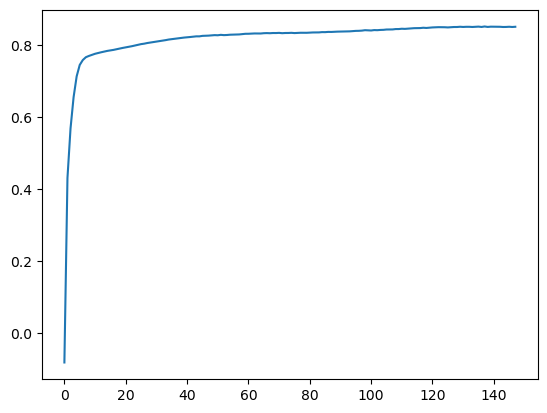

Mean squared error: 0.004632719326764345


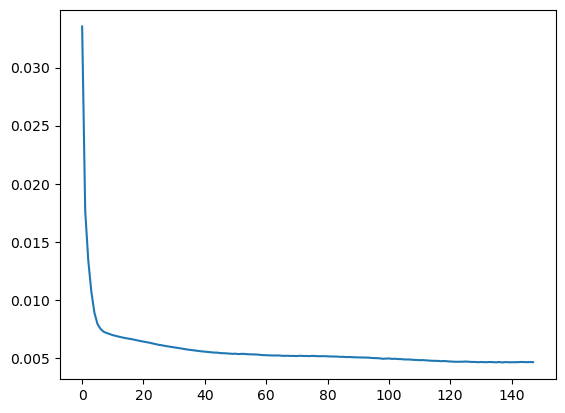

Root Mean squared error: 0.06806408250145113
[0.46470988 0.55813366 0.441006   ... 0.5924729  0.63206565 0.64074576]
(1165,)
<class 'numpy.ndarray'>


In [9]:
print(f"R-Squared: {best_r2}")
plt.plot(history_r2)
plt.show()

print(f"Mean squared error: {best_mse}")
plt.plot(history_mse)
plt.show()

print(f"Root Mean squared error: {np.sqrt(best_mse)}")

real_X_test_tensor = torch.tensor(real_X_test, dtype=torch.float32)
y_pred = model(real_X_test_tensor)
y_pred = y_pred.detach().numpy().flatten()
print(y_pred)
print(y_pred.shape)
print(type(y_pred))

# Training R-Squared: 0.8507387638092041
# Test Mean squared error: 0.004632719326764345
# Test Root Mean squared error: 0.06806408250145113
# [0.46470988 0.55813366 0.441006   ... 0.5924729  0.63206565 0.64074576]
# (1165,)
# <class 'numpy.ndarray'>

### Creating our submission

In [10]:
submission = pd.DataFrame.from_dict({'Completion_rate': y_pred})
submission

,Completion_rate
0,0.464710
1,0.558134
2,0.441006
3,0.444758
4,0.572947
...,...
1160,0.516779
1161,0.512836
1162,0.592473
1163,0.632066


In [11]:
submission.to_csv('submission.csv', index = True, index_label = "id") 

### To submit your submission

On the panel on your right, select the drop down "Submit to competition", and submit this notebook. Ensure that your submission is named ```submission.csv```!